In [1]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import optuna, gc
from collections import Counter
from transformers import EarlyStoppingCallback

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config the variable
CSV_PATH  = "2_processed_data/labelled_dataset_revised.csv"
TEXT_COL  = "sentence"
LABEL_COL = "revised_argument_type"
VALID = ['C', 'G', 'W/Q', 'OTH']

# Load and data preparation
df = pd.read_csv(CSV_PATH).dropna(subset=[TEXT_COL, LABEL_COL])
df = df[df[LABEL_COL].isin(VALID)].copy()

label2id = {l:i for i,l in enumerate(VALID)}
id2label = {i:l for l,i in label2id.items()}
df["label"] = df[LABEL_COL].map(label2id).astype(int)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df[TEXT_COL].astype(str).tolist(),
    df["label"].tolist(),
    test_size=0.2, stratify=df["label"], random_state=42
)

In [3]:
# Model and Tokenizer
model_ckpt = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

MAX_LEN = 96

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

train_ds = Dataset.from_dict({"text": train_texts, "label": train_labels}).map(
    tokenize, batched=True, num_proc=1, remove_columns=["text"]
)
val_ds = Dataset.from_dict({"text": val_texts, "label": val_labels}).map(
    tokenize, batched=True, num_proc=1, remove_columns=["text"]
)

cols = ["input_ids", "attention_mask", "label"]
train_ds = train_ds.with_format(type="torch", columns=cols)
val_ds   = val_ds.with_format(type="torch", columns=cols)

Map: 100%|██████████| 21707/21707 [00:00<00:00, 31302.64 examples/s]


In [4]:
# QLoRA (4-bit) + LoRA
# 4-bit quantization config for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

# Load base model quantized in 4-bit
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(VALID),
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_model.config.pad_token_id = tokenizer.pad_token_id

# Prepare for k-bit training + LoRA
base_model = prepare_model_for_kbit_training(base_model)

lora_cfg = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)
model = get_peft_model(base_model, lora_cfg)
model.print_trainable_parameters()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, pad_to_multiple_of=8)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 6,316,032 || all params: 1,040,836,608 || trainable%: 0.6068


In [5]:
# Metrics
def compute_metrics(pred):
    from sklearn.metrics import accuracy_score, f1_score
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {"accuracy": accuracy_score(labels, preds), "f1_macro": f1_score(labels, preds, average="macro")}

In [ ]:
# Training
args = TrainingArguments(
    output_dir="model/llama_qlora/results",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="no",
    load_best_model_at_end=False,

    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,

    learning_rate=2e-5,
    weight_decay=0.05,
    num_train_epochs=2,

    optim="paged_adamw_8bit",

    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_prefetch_factor=2,

    logging_dir="model/llama_qlora/logs",
    logging_steps=100,
    report_to=2,
)

In [ ]:
# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

C:\Users\user\AppData\Local\Temp\ipykernel_19060\3792864128.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.579900,0.324109,0.876491,0.850472
2,2.267000,0.294225,0.888699,0.863847


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=10854, training_loss=3.0659375195128056, metrics={'train_runtime': 33563.1427, 'train_samples_per_second': 5.174, 'train_steps_per_second': 0.323, 'total_flos': 9.75519075336192e+16, 'train_loss': 3.0659375195128056, 'epoch': 2.0})


=== Classification Report (LLaMA QLoRA) ===
              precision    recall  f1-score   support

           C       0.89      0.88      0.88      3388
           G       0.90      0.91      0.91      5736
         W/Q       0.91      0.93      0.92      9830
         OTH       0.78      0.72      0.75      2753

    accuracy                           0.89     21707
   macro avg       0.87      0.86      0.86     21707
weighted avg       0.89      0.89      0.89     21707

Confusion Matrix:
 [[2989   44  203  152]
 [  53 5222  308  153]
 [ 169  294 9096  271]
 [ 156  243  370 1984]]


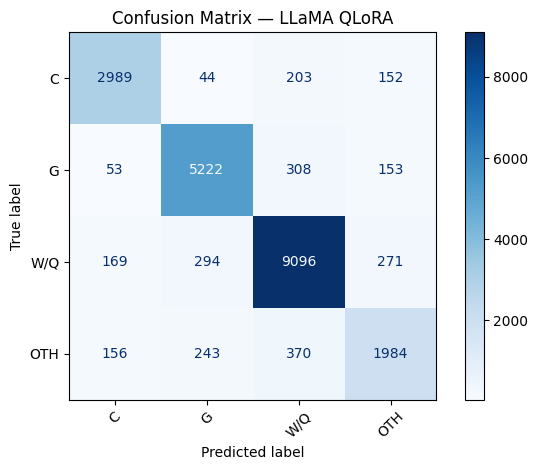

In [ ]:
# Evaluation
preds = trainer.predict(val_ds)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = np.array(val_labels)

print("\n=== Classification Report (LLaMA QLoRA) ===")
print(classification_report(
    y_true, y_pred,
    labels=list(range(len(VALID))),
    target_names=[id2label[i] for i in range(len(VALID))],
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(VALID))))
print("Confusion Matrix:\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id2label[i] for i in range(len(VALID))])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix — LLaMA QLoRA")
plt.tight_layout(); plt.show()


=== ROC AUCs ===
C: AUC = 0.9906
G: AUC = 0.9888
W/Q: AUC = 0.9823
OTH: AUC = 0.9689
Micro-average AUC: 0.9859
Macro-average AUC: 0.9827


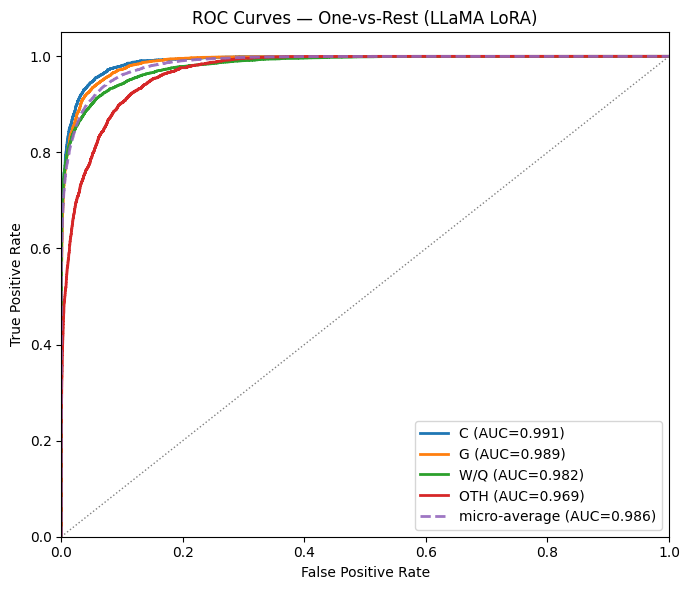

In [ ]:
# ROC / AUC (one-vs-rest)
# Map ids to names from VALID list
inv_label_map = {i: name for i, name in enumerate(VALID)}

# Get class probabilities from logits
probs_all = softmax(preds.predictions, axis=1)  # shape: (n_samples, n_classes)

# Classes actually present in the validation labels (avoids ROC errors if a class is missing)
labels_present = sorted(set(y_true))
class_names_present = [inv_label_map[i] for i in labels_present]

# Binarize true labels over the present classes (keeps shapes aligned)
y_true_bin = label_binarize(np.array(y_true), classes=labels_present)

# Align probs to the present classes (columns are class indices)
probs = probs_all[:, labels_present]

# Compute per-class ROC and AUC
fprs, tprs, aucs = {}, {}, {}
for j, cls_id in enumerate(labels_present):
    # Skip if no positive samples for this class in y_true
    if y_true_bin[:, j].sum() == 0:
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, j], probs[:, j])
    fprs[cls_id], tprs[cls_id] = fpr, tpr
    aucs[cls_id] = auc(fpr, tpr)

# Micro-average ROC/AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), probs.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average AUC (mean across available per-class AUCs)
auc_macro = float(np.mean(list(aucs.values()))) if len(aucs) > 0 else float("nan")

# Print AUCs
print("\n=== ROC AUCs ===")
for cls_id in labels_present:
    name = inv_label_map[cls_id]
    if cls_id in aucs:
        print(f"{name}: AUC = {aucs[cls_id]:.4f}")
    else:
        print(f"{name}: AUC = N/A (no positive examples)")
print(f"Micro-average AUC: {auc_micro:.4f}")
print(f"Macro-average AUC: {auc_macro:.4f}")

# Plot ROC curves
plt.figure(figsize=(7, 6))

# Per-class curves
for cls_id in labels_present:
    if cls_id in fprs:
        plt.plot(fprs[cls_id], tprs[cls_id], lw=2,
                 label=f"{inv_label_map[cls_id]} (AUC={aucs[cls_id]:.3f})")

# Micro-average
plt.plot(fpr_micro, tpr_micro, lw=2, linestyle="--",
         label=f"micro-average (AUC={auc_micro:.3f})", alpha=0.9)

# Chance line
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle=":")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — One-vs-Rest (LLaMA LoRA)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [ ]:
# Save LoRA adapter + tokenizer
adapter_dir = "3_model/llama_qlora"
os.makedirs(adapter_dir, exist_ok=True)
trainer.model.save_pretrained(adapter_dir)
tokenizer.save_pretrained(adapter_dir)
print("Saved LoRA adapter to:", adapter_dir)

Saved LoRA adapter to: llama_qlora/adapter


In [6]:
# --- detect debate/filename column ---
filename_col = None
for cand in ["filename", "file_name", "debate_id", "doc", "source", "file", "topic_id"]:
    if cand in df.columns:
        filename_col = cand
        break
if filename_col is None:
    raise ValueError("No debate identifier column found. Please ensure dataset has an ID column.")

# --- sample 40 debates ---
unique_files = df[filename_col].dropna().unique().tolist()
rng = np.random.default_rng(42)
sampled_files = rng.choice(unique_files, size=min(100, len(unique_files)), replace=False).tolist()
df_sample = df[df[filename_col].isin(sampled_files)].copy()

In [7]:
print("\n=== SAMPLE SUMMARY ===")
print(f"Sampled debates: {len(sampled_files)}, Rows: {len(df_sample)}")
print("Label balance:", Counter(df_sample["label"]))
print("Sampled file examples:", sampled_files[:5])


=== SAMPLE SUMMARY ===
Sampled debates: 100, Rows: 2931
Label balance: Counter({2: 1251, 1: 870, 0: 458, 3: 352})
Sampled file examples: ['YBA_661_mandatory-retirement_con_DJ_explicit.trs.txt', 'WS_3196_immigration-us_pro.trs.txt', 'SSH_3301_freedom-of-speech_con_DJ_implicit.trs.txt', 'RG_2143_ban-abortions_pro.trs.txt', 'JL_985_free-market_con_TL_implicit.trs.txt']


In [8]:
# --- split sampled subset ---
train_s, val_s = train_test_split(
    df_sample[[TEXT_COL, "label"]],
    test_size=0.2,
    stratify=df_sample["label"],
    random_state=42
)

In [9]:
print("\n=== SAMPLE SPLIT ===")
print(f"Train: {len(train_s)} | Val: {len(val_s)}")
print("Train balance:", Counter(train_s["label"]))
print("Val balance:", Counter(val_s["label"]))


=== SAMPLE SPLIT ===
Train: 2344 | Val: 587
Train balance: Counter({2: 1000, 1: 696, 0: 366, 3: 282})
Val balance: Counter({2: 251, 1: 174, 0: 92, 3: 70})


In [10]:
def make_hf_ds(train_df, val_df, max_length=96):
    def tok_fn(batch):
        return tokenizer(
            batch[TEXT_COL],
            truncation=True,
            padding="max_length",
            max_length=max_length,
        )
    tr_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(
        tok_fn, batched=True, remove_columns=[TEXT_COL]
    )
    va_ds = Dataset.from_pandas(val_df.reset_index(drop=True)).map(
        tok_fn, batched=True, remove_columns=[TEXT_COL]
    )
    cols = ["input_ids", "attention_mask", "label"]
    return tr_ds.with_format(type="torch", columns=cols), va_ds.with_format(type="torch", columns=cols)

In [11]:
def free_mem(objs):
    for o in objs:
        try: del o
        except: pass
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [16]:
# --- objective ---
def objective(trial):
    lr           = trial.suggest_float("learning_rate", 5e-6, 5e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.1)
    warmup_ratio = trial.suggest_float("warmup_ratio", 0.0, 0.15)
    batch_size   = trial.suggest_categorical("per_device_train_batch_size", [2, 4])
    grad_accum   = trial.suggest_categorical("gradient_accumulation_steps", [4, 8])
    max_len      = trial.suggest_categorical("max_length", [64, 96, 128])
    num_epochs   = trial.suggest_categorical("num_train_epochs", [1, 2])

    # LoRA params
    lora_r       = trial.suggest_categorical("lora_r", [4, 8, 16])
    lora_alpha   = trial.suggest_categorical("lora_alpha", [8, 16, 32])
    lora_dropout = trial.suggest_float("lora_dropout", 0.0, 0.1)

    tr_ds, va_ds = make_hf_ds(train_s, val_s, max_length=max_len)

    base = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(VALID),
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
    )
    base.config.pad_token_id = tokenizer.pad_token_id
    base = prepare_model_for_kbit_training(base)

    lcfg = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=lora_r, lora_alpha=lora_alpha, lora_dropout=lora_dropout,
        bias="none",
        target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
    )
    model_hpo = get_peft_model(base, lcfg)

    args = TrainingArguments(
        output_dir=f"model/llama_qlora/hpo_trial_{trial.number}",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=min(batch_size, 8),
        gradient_accumulation_steps=grad_accum,
        learning_rate=lr,
        weight_decay=weight_decay,
        warmup_ratio=warmup_ratio,
        num_train_epochs=num_epochs,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        report_to=[],
    )

    trainer_hpo = Trainer(
        model=model_hpo,
        args=args,
        train_dataset=tr_ds,
        eval_dataset=va_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    try:
        trainer_hpo.train()
        score = trainer_hpo.evaluate(va_ds)["eval_f1_macro"]
    except RuntimeError as e:
        print(f"[Trial {trial.number}] OOM: {e}")
        score = 0.0

    free_mem([trainer_hpo, model_hpo, base, tr_ds, va_ds])
    return score

In [19]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-09-07 00:02:13,997] A new study created in memory with name: no-name-73b50a62-fe46-48d6-972e-eefc58a0860f
Map: 100%|██████████| 587/587 [00:00<00:00, 30854.38 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo = Trainer(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,5.898200,1.452420,0.403748,0.266555


[I 2025-09-07 00:08:15,114] Trial 0 finished with value: 0.26655510783673014 and parameters: {'learning_rate': 1.5312868633051215e-05, 'weight_decay': 0.03160324942258293, 'warmup_ratio': 0.052950769455300736, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 64, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 8, 'lora_dropout': 0.07824220129105786}. Best is trial 0 with value: 0.26655510783673014.
Map: 100%|██████████| 587/587 [00:00<00:00, 29340.93 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,4.736300,1.066071,0.538330,0.512124


[I 2025-09-07 00:16:00,570] Trial 1 finished with value: 0.5121236952502615 and parameters: {'learning_rate': 3.601923684544893e-05, 'weight_decay': 0.0625624119486144, 'warmup_ratio': 0.1459507533093667, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 96, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.021841059641805508}. Best is trial 1 with value: 0.5121236952502615.
Map: 100%|██████████| 587/587 [00:00<00:00, 26630.93 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,12.012300,1.333470,0.379898,0.284632


[I 2025-09-07 00:21:53,661] Trial 2 finished with value: 0.2846318048460521 and parameters: {'learning_rate': 3.556032377035645e-05, 'weight_decay': 0.007302121375464388, 'warmup_ratio': 0.032059286905494505, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 8, 'max_length': 64, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.05208307958070305}. Best is trial 1 with value: 0.5121236952502615.
Map: 100%|██████████| 587/587 [00:00<00:00, 27952.50 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_h

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,3.454200,0.775512,0.684838,0.637278


[I 2025-09-07 00:32:10,001] Trial 3 finished with value: 0.6372780454871406 and parameters: {'learning_rate': 7.448221240526385e-05, 'weight_decay': 0.0008753959467410866, 'warmup_ratio': 0.12289487475080486, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 4, 'max_length': 96, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 32, 'lora_dropout': 0.02494485553131992}. Best is trial 3 with value: 0.6372780454871406.
Map: 100%|██████████| 587/587 [00:00<00:00, 29347.93 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_h

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,6.076700,1.428290,0.340716,0.242722
2,5.351300,1.345584,0.388416,0.283921


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[I 2025-09-07 00:43:32,884] Trial 4 finished with value: 0.28392139608091743 and parameters: {'learning_rate': 1.3074404194880005e-05, 'weight_decay': 0.01674716973931245, 'warmup_ratio': 0.125090853679508, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 64, 'num_train_epochs': 2, 'lora_r': 4, 'lora_alpha': 8, 'lora_dropout': 0.03896899055663627}. Best is trial 3 with value: 0.6372780454871406.
Map: 100%|██████████| 587/587 [00:00<00:00, 26663.52 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo =

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,6.332900,1.457549,0.328790,0.221499
2,5.898200,1.411649,0.340716,0.226088


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[I 2025-09-07 00:54:54,999] Trial 5 finished with value: 0.22608847554211792 and parameters: {'learning_rate': 6.301690669874866e-06, 'weight_decay': 0.07340380320813211, 'warmup_ratio': 0.11771053175066101, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 4, 'max_length': 64, 'num_train_epochs': 2, 'lora_r': 8, 'lora_alpha': 16, 'lora_dropout': 0.0404120981538865}. Best is trial 3 with value: 0.6372780454871406.
Map: 100%|██████████| 587/587 [00:00<00:00, 20241.18 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,10.858400,1.242625,0.427598,0.352511


[I 2025-09-07 01:05:07,561] Trial 6 finished with value: 0.3525111452088656 and parameters: {'learning_rate': 3.882536707141186e-05, 'weight_decay': 0.02220610037029891, 'warmup_ratio': 0.039235722439650525, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'max_length': 96, 'num_train_epochs': 1, 'lora_r': 8, 'lora_alpha': 8, 'lora_dropout': 0.08500990749227726}. Best is trial 3 with value: 0.6372780454871406.
Map: 100%|██████████| 587/587 [00:00<00:00, 25522.27 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo 

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,7.921000,0.720629,0.710392,0.661447
2,3.516600,0.681470,0.722317,0.668623


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


[I 2025-09-07 01:24:55,147] Trial 7 finished with value: 0.6686226579061819 and parameters: {'learning_rate': 0.0001593475501651878, 'weight_decay': 0.04011490377308109, 'warmup_ratio': 0.008224698649940703, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'max_length': 96, 'num_train_epochs': 2, 'lora_r': 4, 'lora_alpha': 16, 'lora_dropout': 0.061540017229769685}. Best is trial 7 with value: 0.6686226579061819.
Map: 100%|██████████| 587/587 [00:00<00:00, 22574.21 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hp

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,12.644200,1.496632,0.289608,0.234290


[I 2025-09-07 01:35:10,841] Trial 8 finished with value: 0.234290354957525 and parameters: {'learning_rate': 5.368256814350094e-06, 'weight_decay': 0.06920683638519667, 'warmup_ratio': 0.0019716362267413134, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'max_length': 96, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 8, 'lora_dropout': 0.09038543288769499}. Best is trial 7 with value: 0.6686226579061819.
Map: 100%|██████████| 587/587 [00:00<00:00, 18942.39 examples/s]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_70304\1634882094.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_hpo

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,11.972200,1.468514,0.332198,0.228369


[I 2025-09-07 01:45:26,249] Trial 9 finished with value: 0.22836921054490236 and parameters: {'learning_rate': 7.998898737699603e-06, 'weight_decay': 0.005444100064996827, 'warmup_ratio': 0.014033972073078504, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'max_length': 96, 'num_train_epochs': 1, 'lora_r': 16, 'lora_alpha': 16, 'lora_dropout': 0.035040059052860006}. Best is trial 7 with value: 0.6686226579061819.


In [20]:
print("\n=== BEST HPO ===")
print("f1_macro:", study.best_value)
print("params:", study.best_params)


=== BEST HPO ===
f1_macro: 0.6686226579061819
params: {'learning_rate': 0.0001593475501651878, 'weight_decay': 0.04011490377308109, 'warmup_ratio': 0.008224698649940703, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'max_length': 96, 'num_train_epochs': 2, 'lora_r': 4, 'lora_alpha': 16, 'lora_dropout': 0.061540017229769685}


In [21]:
best = study.best_params.copy()
best_max_len = best.pop("max_length", MAX_LEN)
_ = best.pop("num_train_epochs", None)

In [22]:
# --- retrain on full dataset ---
train_full, val_full = train_test_split(
    df[[TEXT_COL, "label"]],
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)
train_ds_full, val_ds_full = make_hf_ds(train_full, val_full, max_length=best_max_len)

Map: 100%|██████████| 21707/21707 [00:00<00:00, 26956.79 examples/s]


In [23]:
base_final = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=len(VALID),
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
base_final.config.pad_token_id = tokenizer.pad_token_id
base_final = prepare_model_for_kbit_training(base_final)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at TinyLlama/TinyLlama-1.1B-Chat-v1.0 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
lcfg_final = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=best.get("lora_r", 8),
    lora_alpha=best.get("lora_alpha", 16),
    lora_dropout=best.get("lora_dropout", 0.05),
    bias="none",
    target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj"],
)
model_final = get_peft_model(base_final, lcfg_final)

In [25]:
final_epochs = 3
args_final = TrainingArguments(
    output_dir="model/llama_qlora/final_best",
    per_device_train_batch_size=best.get("per_device_train_batch_size", 2),
    per_device_eval_batch_size=min(best.get("per_device_train_batch_size", 2), 8),
    gradient_accumulation_steps=best.get("gradient_accumulation_steps", 8),
    learning_rate=best.get("learning_rate", 2e-5),
    weight_decay=best.get("weight_decay", 0.01),
    warmup_ratio=best.get("warmup_ratio", 0.0),
    num_train_epochs=final_epochs,
    eval_strategy="epoch",
    save_strategy="no",
    logging_steps=100,
    report_to=[],
)

In [28]:
trainer_final = Trainer(
    model=model_final,
    args=args_final,
    train_dataset=train_ds_full,
    eval_dataset=val_ds_full,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

C:\Users\user\AppData\Local\Temp\ipykernel_70304\4125956908.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_final = Trainer(


In [29]:
trainer_final.train()

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,2.348600,0.260566,0.899894,0.875657
2,1.708300,0.276121,0.912885,0.890937
3,0.852600,0.573133,0.915788,0.894718


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, 

TrainOutput(global_step=16281, training_loss=1.801593168047911, metrics={'train_runtime': 63072.537, 'train_samples_per_second': 4.13, 'train_steps_per_second': 0.258, 'total_flos': 1.458546673287168e+17, 'train_loss': 1.801593168047911, 'epoch': 3.0})

In [30]:
# --- evaluation ---
preds_final = trainer_final.predict(val_ds_full)
y_true_final = preds_final.label_ids
y_pred_final = np.argmax(preds_final.predictions, axis=1)

print("\n=== FINAL REPORT (TinyLLaMA QLoRA) ===")
print(classification_report(
    y_true_final, y_pred_final,
    labels=list(range(len(VALID))),
    target_names=VALID,
    zero_division=0
))



=== FINAL REPORT (TinyLLaMA QLoRA) ===
              precision    recall  f1-score   support

           C       0.92      0.90      0.91      3388
           G       0.92      0.93      0.93      5736
         W/Q       0.95      0.94      0.94      9830
         OTH       0.79      0.80      0.80      2753

    accuracy                           0.92     21707
   macro avg       0.89      0.89      0.89     21707
weighted avg       0.92      0.92      0.92     21707



Confusion Matrix:
 [[3052   39  124  173]
 [  33 5341  193  169]
 [ 114  192 9275  249]
 [ 111  218  213 2211]]


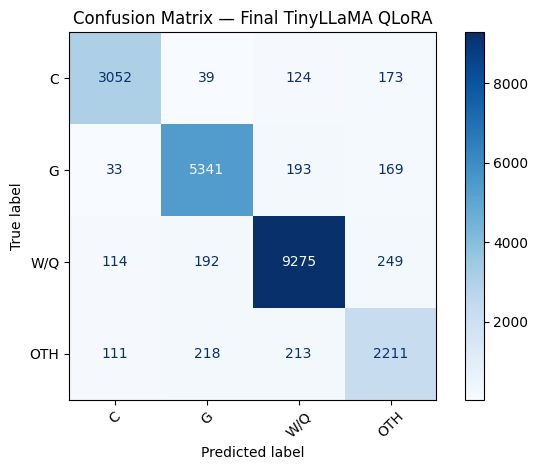

In [31]:
cm = confusion_matrix(y_true_final, y_pred_final, labels=list(range(len(VALID))))
print("Confusion Matrix:\n", cm)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=VALID).plot(
    cmap=plt.cm.Blues, xticks_rotation=45
)
plt.title("Confusion Matrix — Final TinyLLaMA QLoRA")
plt.tight_layout(); plt.show()

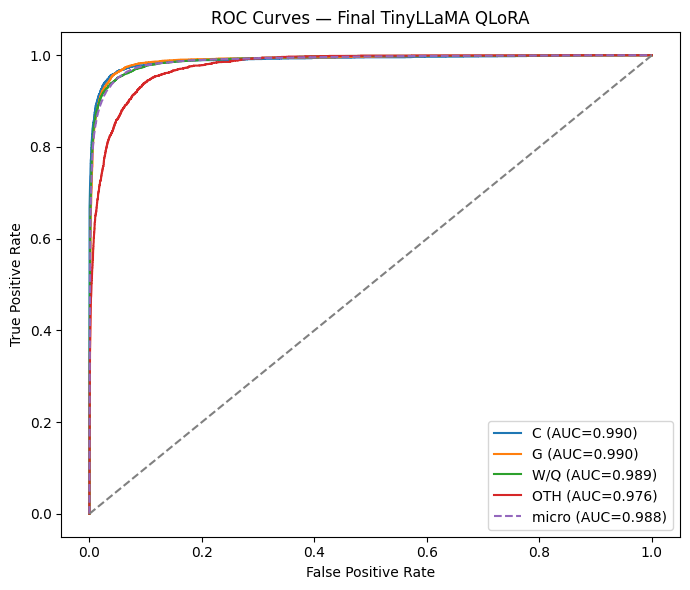

In [32]:
# --- ROC/AUC ---
probs_all = softmax(preds_final.predictions, axis=1)
y_true_bin = label_binarize(y_true_final, classes=list(range(len(VALID))))
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(VALID)):
    if y_true_bin[:, i].sum() > 0:
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], probs_all[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
roc_auc["macro"] = np.mean(list(roc_auc.values()))

plt.figure(figsize=(7,6))
for i in range(len(VALID)):
    if i in fpr:
        plt.plot(fpr[i], tpr[i], label=f"{VALID[i]} (AUC={roc_auc[i]:.3f})")
plt.plot(fpr["micro"], tpr["micro"], linestyle="--", label=f"micro (AUC={roc_auc['micro']:.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Final TinyLLaMA QLoRA")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

In [33]:
# --- save best model ---
SAVE_DIR = "3_model/tinyllama_qlora_best"
trainer_final.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)
print("Saved final best TinyLLaMA QLoRA model to:", SAVE_DIR)
print("Best HPO params:", {**best, "max_length": best_max_len, "final_epochs": final_epochs})

Saved final best TinyLLaMA QLoRA model to: 3_model/tinyllama_qlora_best
Best HPO params: {'learning_rate': 0.0001593475501651878, 'weight_decay': 0.04011490377308109, 'warmup_ratio': 0.008224698649940703, 'per_device_train_batch_size': 2, 'gradient_accumulation_steps': 8, 'lora_r': 4, 'lora_alpha': 16, 'lora_dropout': 0.061540017229769685, 'max_length': 96, 'final_epochs': 3}
